## Exercise 18

#### Analysis of Temperatures

In the attached file temperatures_dortmund.csv you will find the weather data for the period 2000-
2008, provided by the city of Dortmund, published in the Open Data Portal1
.
The data has been lightly edited to make it easier for you to analyze. In particular, the measurement times of dates (columns Date and Time) of the type DD.MM.YYYY HH:MM were additionally
converted to decimal values (column Measurement), which can lead to minor fluctuations due to the
non-uniform length of the year, which you may neglect. The original readings were taken using 15 min
or 10 min intervals as of September 18, 2008. The temperature data (column Temperature) are in
degrees Celsius. Other columns present in the original data were removed, placeholders for missing
values were replaced with NaN.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
from scipy.signal import lombscargle

#### a)

In [2]:
df = pd.read_csv('temperatures_dortmund.csv')
print(df)

              Date   Time  Measurement  Temperature
0       01.01.2000  00:00  2000.000000          3.0
1       01.01.2000  00:15  2000.000028          3.0
2       01.01.2000  00:30  2000.000057          3.0
3       01.01.2000  00:45  2000.000085          3.0
4       01.01.2000  01:00  2000.000114          3.0
...            ...    ...          ...          ...
307885  31.12.2008  23:10  2008.999905         -4.0
307886  31.12.2008  23:20  2008.999924         -3.0
307887  31.12.2008  23:30  2008.999943         -3.0
307888  31.12.2008  23:40  2008.999962         -4.0
307889  31.12.2008  23:50  2008.999981         -4.0

[307890 rows x 4 columns]


We can not apply a Fourier analysis on this dataset, because the measurement did not give us equally spaced data. But we can apply a Lomb-Scargle periodogram.

#### b)

To apply a Lomb-Scale perdiodogram we cannot have NaN values in our dataset.


In [3]:
df = df.dropna() # delete all NaN entries
df = df[df.Measurement < 2009] #after doing the periodogram the scale went up to 10^6 so we limit the time onto 2009

#### c)


In [4]:
data = df.to_numpy()

x = data[:,2]
y_0 = data[:,3]
n_frequencies = 1000
f = np.linspace(0.0001, 1.25, n_frequencies)
f_0 = np.linspace(0.0001, 0.001, n_frequencies)
f_inf = np.linspace(0.0001, 100, n_frequencies)

pgram = lombscargle(x, y_0, 2*np.pi*f, normalize=True)
pgram_0 = lombscargle(x, y_0, 2*np.pi*f_0, normalize=True)
pgram_inf = lombscargle(x, y_0, 2*np.pi*f_inf, normalize=True)

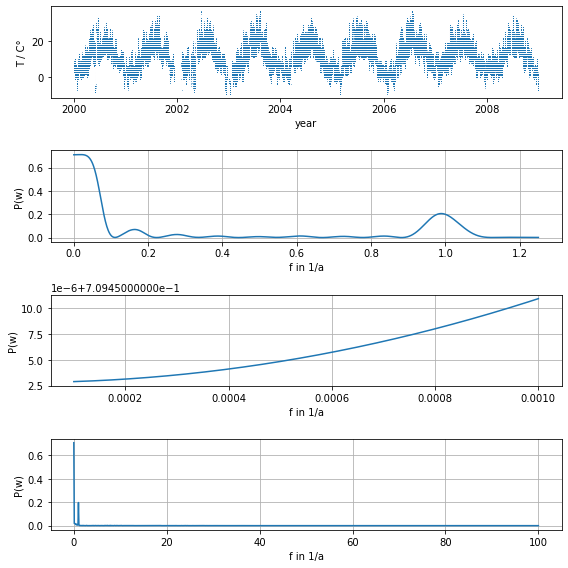

In [5]:
fig, ax = plt.subplots(4,1, figsize=(8, 8))

ax[0].plot(x, y_0, marker = "|", markersize = 0.5, lw = 0.001,)
#ax[0].grid()
ax[0].set_xlabel("year")
ax[0].set_ylabel("T / C°")

ax[1].plot(f, pgram)
ax[1].grid()
#ax[1].set_xlim(0, 2)
ax[1].set_xlabel("f in 1/a")
ax[1].set_ylabel("P(w)")

ax[2].plot(f_0, pgram_0)
ax[2].grid()
ax[2].set_xlabel("f in 1/a")
ax[2].set_ylabel("P(w)")

ax[3].plot(f_inf, pgram_inf)
ax[3].grid()
ax[3].set_xlabel("f in 1/a")
ax[3].set_ylabel("P(w)")

fig.tight_layout()

For Frequencies with a periodicity in scale of day/week/month was not possible a resolution was not possible. So we tested from (not equal to zero) 0 to 1.2, as seen in the 2nd plot. The 4th plot shows that after 1.2 there is no contribution.

In plot 2 we see a peak, which was expected. But the plots do not show temprature fluctuations in the scale of days.

#### d)

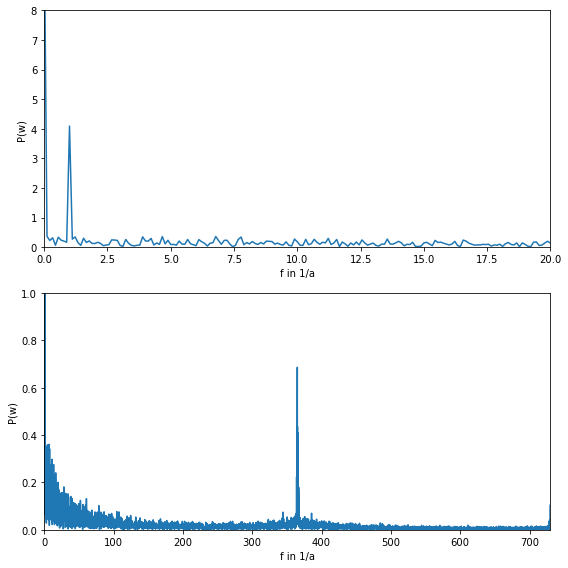

In [6]:
from scipy.interpolate import interp1d
from scipy.fft import rfft, rfftfreq, irfft

x = np.array(x).astype(float)
distance = 1/(365*24*4)

def grid_data_fft(xx, yy, grid_spacing):
    xi = np.arange(xx.min(), xx.max(), grid_spacing)
    f = interp1d(xx, yy)
    yi = f(xi)
    return xi, yi

x_grid, y_0grid = grid_data_fft(x, y_0, distance)


signal_fft = rfft(y_0grid, norm = "forward")
frequencies = rfftfreq(len(x_grid), distance)

fig, ax = plt.subplots(2,1, figsize=(8, 8))
ax[0].plot(frequencies, np.abs(signal_fft))
ax[0].set_xlim(0, 20)
ax[0].set_ylim(0, 8)
ax[0].set_xlabel("f in 1/a")
ax[0].set_ylabel("P(w)")

ax[1].plot(frequencies, np.abs(signal_fft))
ax[1].set_xlim(0, 2*365)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel("f in 1/a")
ax[1].set_ylabel("P(w)")

fig.tight_layout()

#### e)

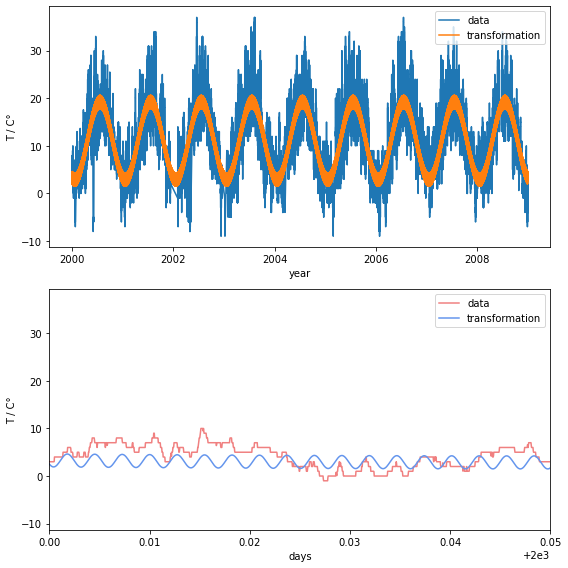

In [7]:
signal_fft_r = signal_fft
signal_fft_r[np.abs(signal_fft)<0.6] = 0


inv_signal_fft_r = irfft(signal_fft_r, len(signal_fft_r), norm = "forward")
x = np.linspace(2000, 2008.999981, 157681)


fig, ax = plt.subplots(2,1, figsize=(8, 8))

ax[0].plot(x_grid, y_0grid, label ="data")
ax[0].plot(x, inv_signal_fft_r, label ="transformation")
ax[0].set_xlabel("year")
ax[0].set_ylabel("T / C°")
ax[0].legend()

ax[1].plot(x_grid, y_0grid, label ="data")
ax[1].plot(x, inv_signal_fft_r, label ="transformation")
ax[1].set_xlabel("days")
ax[1].set_ylabel("T / C°")
ax[1].set_xlim(2000,2000.05)
ax[1].legend()

fig.tight_layout()